# Stock Price Prediction Using RNNs
#### Author :  Shriyan Arcot

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, SimpleRNN, Bidirectional, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import os
from functools import reduce
from itertools import product

/Users/ashriyan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [5]:
# Define a function to load data and aggregate them

def join_input_dataset(files):
    dataSet=[]
    for file in files:
        stockData = pd.read_csv(file, parse_dates=['Date'])
        stockName = os.path.basename(file).split('_')[0]
        stockData.drop(columns=['Name'],inplace=True)

        # Rename columns to tag with stock name
        rename_cols = {
            'Open': f'{stockName}_Open',
            'High': f'{stockName}_High',
            'Low': f'{stockName}_Low',
            'Close': f'{stockName}_Close',
            'Volume': f'{stockName}_Volume'
        }
        stockData = stockData.rename(columns=rename_cols)
        dataSet.append(stockData)


    # Merge on Date column
    merged_df = reduce(lambda left, right: pd.merge(
        left, right, on='Date', how='outer'), dataSet)

    return merged_df

In [6]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

files = [
    './RNN_Stocks_Data/AMZN_stocks_data.csv',
    './RNN_Stocks_Data/GOOGL_stocks_data.csv',
    './RNN_Stocks_Data/IBM_stocks_data.csv',
    './RNN_Stocks_Data/MSFT_stocks_data.csv'
]

merged_stocks_df = join_input_dataset(files)
print(merged_stocks_df.head())

        Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
0 2006-01-03      47.47      47.85     46.25       47.58    7582127.0   
1 2006-01-04      47.48      47.73     46.69       47.25    7440914.0   
2 2006-01-05      47.16      48.20     47.11       47.65    5417258.0   
3 2006-01-06      47.97      48.58     47.32       47.87    6154285.0   
4 2006-01-09      46.55      47.10     46.40       47.08    8945056.0   

   GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  IBM_Open  IBM_High  \
0      211.47      218.05     209.32       217.83  ...     82.45     82.55   
1      222.17      224.70     220.09       222.84  ...     82.20     82.50   
2      223.22      226.00     220.97       225.85  ...     81.40     82.90   
3      228.66      235.49     226.85       233.06  ...     83.95     85.03   
4      233.44      236.94     230.70       233.68  ...     84.10     84.25   

   IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  MSFT_High  MSFT_Low  MSFT_Close  \
0    80.81 

In [7]:
# View specifics of the data

print("\nShape of the dataset --")
print(merged_stocks_df.shape)
print("\nInfo:")
print(merged_stocks_df.info())
print("\nSummary Stats:")
print(merged_stocks_df.describe())


Shape of the dataset --
(3020, 21)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3020 non-null   datetime64[ns]
 1   AMZN_Open     3019 non-null   float64       
 2   AMZN_High     3019 non-null   float64       
 3   AMZN_Low      3019 non-null   float64       
 4   AMZN_Close    3019 non-null   float64       
 5   AMZN_Volume   3019 non-null   float64       
 6   GOOGL_Open    3019 non-null   float64       
 7   GOOGL_High    3019 non-null   float64       
 8   GOOGL_Low     3019 non-null   float64       
 9   GOOGL_Close   3019 non-null   float64       
 10  GOOGL_Volume  3019 non-null   float64       
 11  IBM_Open      3019 non-null   float64       
 12  IBM_High      3020 non-null   float64       
 13  IBM_Low       3019 non-null   float64       
 14  IBM_Close     3020 non-null   float64       


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [8]:
# Handle Missing Values
merged_stocks_df.sort_values(by='Date', inplace=True)
merged_stocks_df.reset_index(drop=True, inplace=True)

print("Looking for Null values --")
print(merged_stocks_df.isnull().sum())

print("Looking for row with Null values --")
print(merged_stocks_df[merged_stocks_df.isnull().any(axis=1)])

# Drop the row with mostly missing values
merged_stocks_df.drop(index=1068, inplace=True)
merged_stocks_df.reset_index(drop=True, inplace=True)
# Fill missing IBM values for row 2913 using forward fill
merged_stocks_df = merged_stocks_df.fillna(method='ffill')

print("\nShape after droping the record -- ")
print(merged_stocks_df.shape)

print("\n Again checking for Null values --")
print(merged_stocks_df.isnull().sum())

Looking for Null values --
Date            0
AMZN_Open       1
AMZN_High       1
AMZN_Low        1
AMZN_Close      1
AMZN_Volume     1
GOOGL_Open      1
GOOGL_High      1
GOOGL_Low       1
GOOGL_Close     1
GOOGL_Volume    1
IBM_Open        1
IBM_High        0
IBM_Low         1
IBM_Close       0
IBM_Volume      0
MSFT_Open       1
MSFT_High       1
MSFT_Low        1
MSFT_Close      1
MSFT_Volume     1
dtype: int64
Looking for row with Null values --
           Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
1068 2010-04-01        NaN        NaN       NaN         NaN          NaN   
2913 2017-07-31    1019.05    1019.05    987.02      987.78    7352063.0   

      GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  IBM_Open  IBM_High  \
1068         NaN         NaN        NaN          NaN  ...    128.95    129.31   
2913       960.0      961.19     941.72        945.5  ...       NaN    144.93   

      IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  MSFT_High  MSFT_Low  \
1

/var/folders/5n/zn4pdw1j5bq14bmthb_zx3dh0000gr/T/ipykernel_5954/1093402601.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_stocks_df = merged_stocks_df.fillna(method='ffill')


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

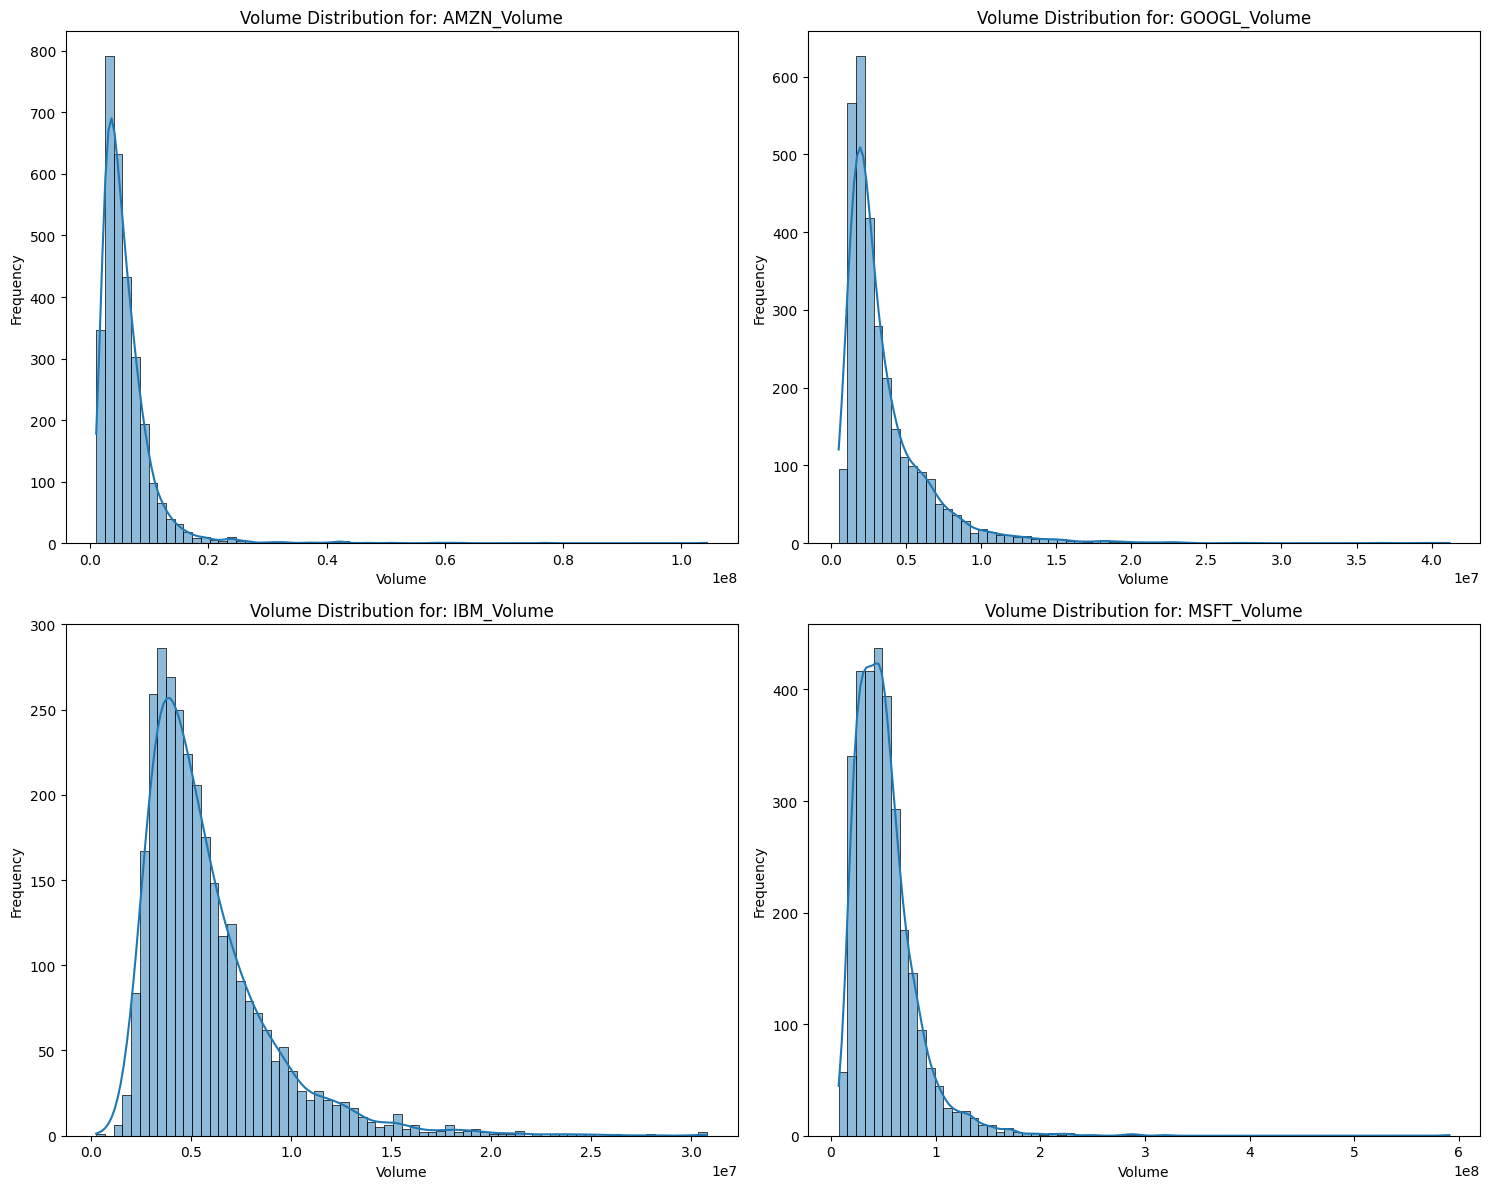

In [9]:
# Frequency distribution of volumes

volumeCols =  [col for col in merged_stocks_df.columns if "volume" in col.lower()]
plt.figure(figsize=(15, 12))
for i, col in enumerate(volumeCols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(merged_stocks_df[col], bins=70, kde=True)
    plt.title(f'Volume Distribution for: {col}')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

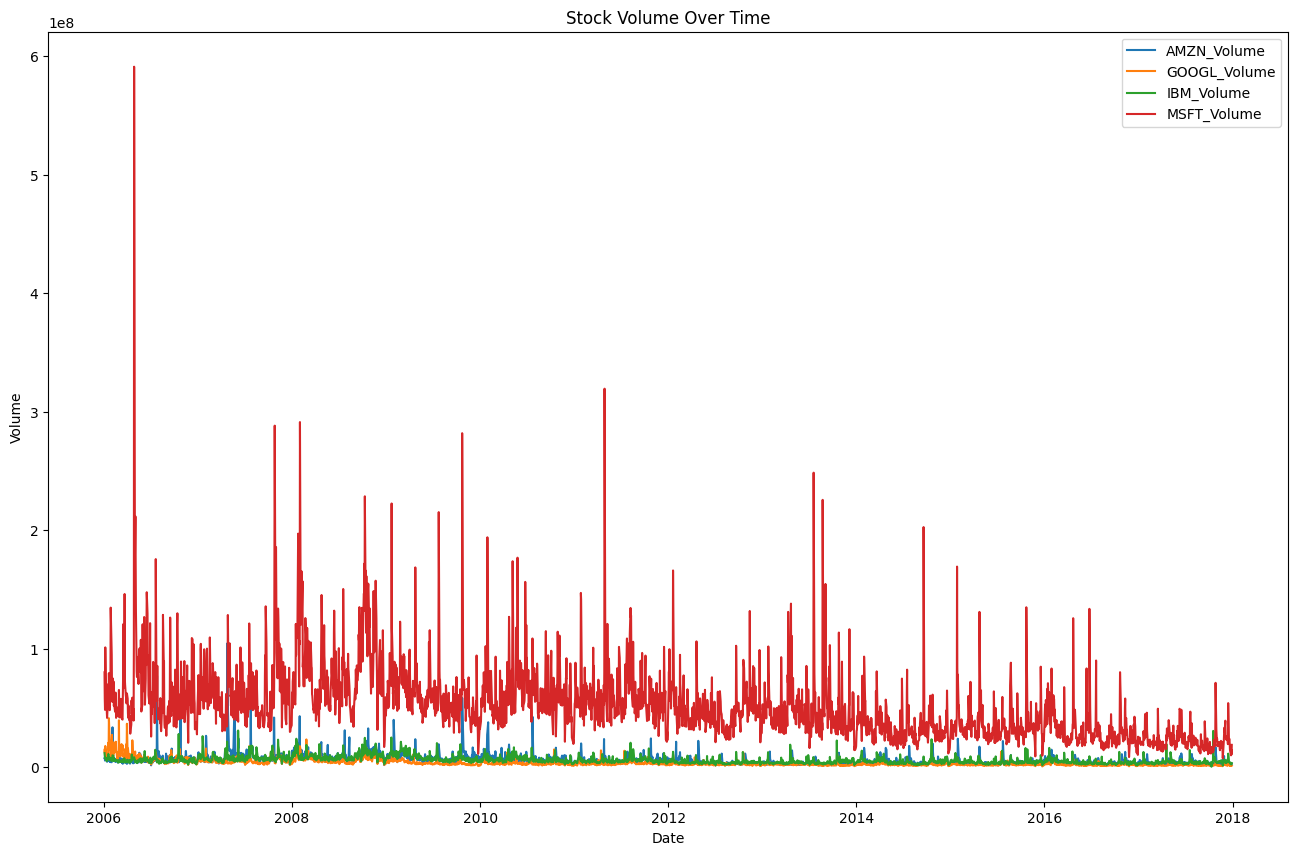

In [10]:
# Stock volume variation over time

plt.figure(figsize=(16, 10))
for col in volumeCols:
    plt.plot(merged_stocks_df['Date'], merged_stocks_df[col], label=col)
plt.title('Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

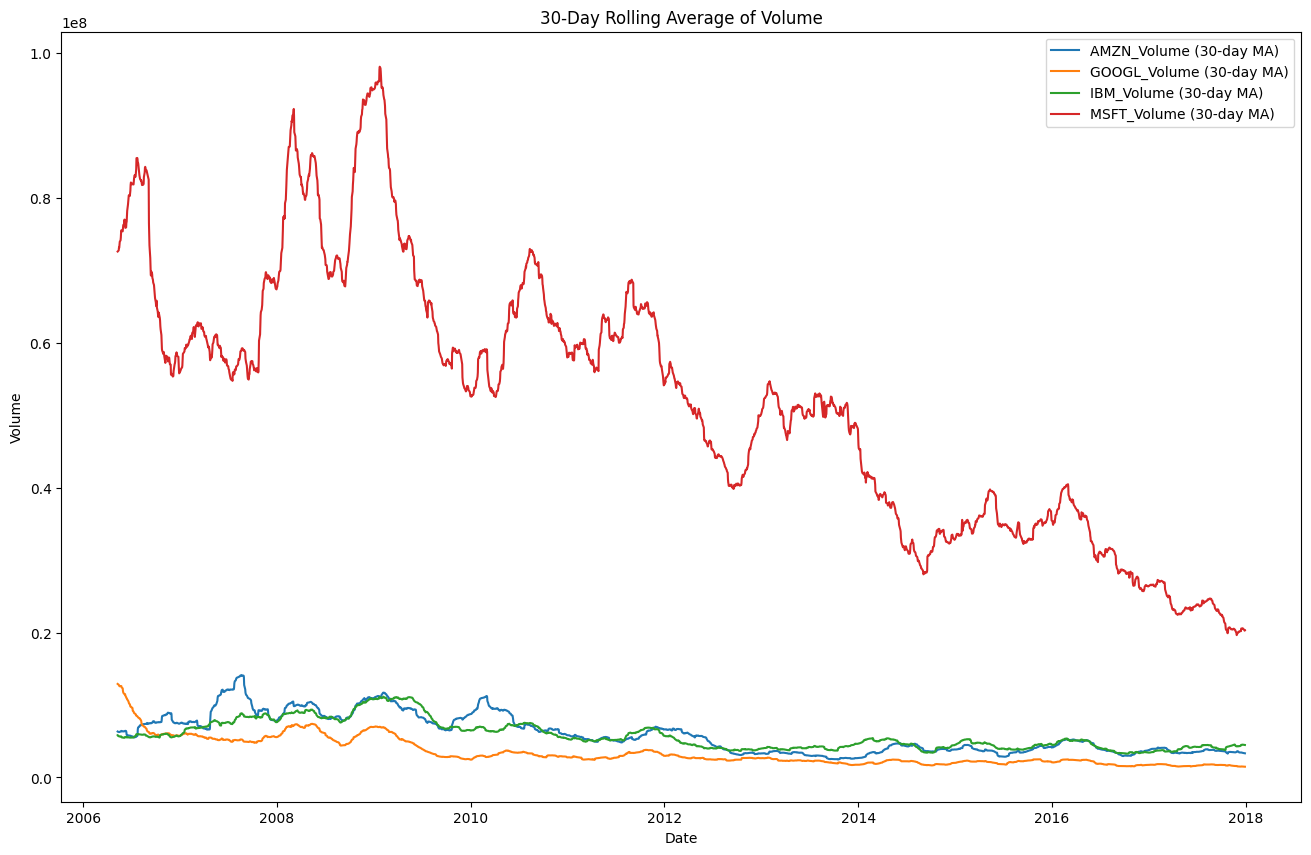

In [11]:
# To smooth the plot and remove daily noise, using rolling average:
plt.figure(figsize=(16, 10))
for col in volumeCols:
    plt.plot(
        merged_stocks_df['Date'],
        merged_stocks_df[col].rolling(window=90).mean(),  # 90-day average
        label=f'{col} (30-day MA)'
    )
plt.title('30-Day Rolling Average of Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

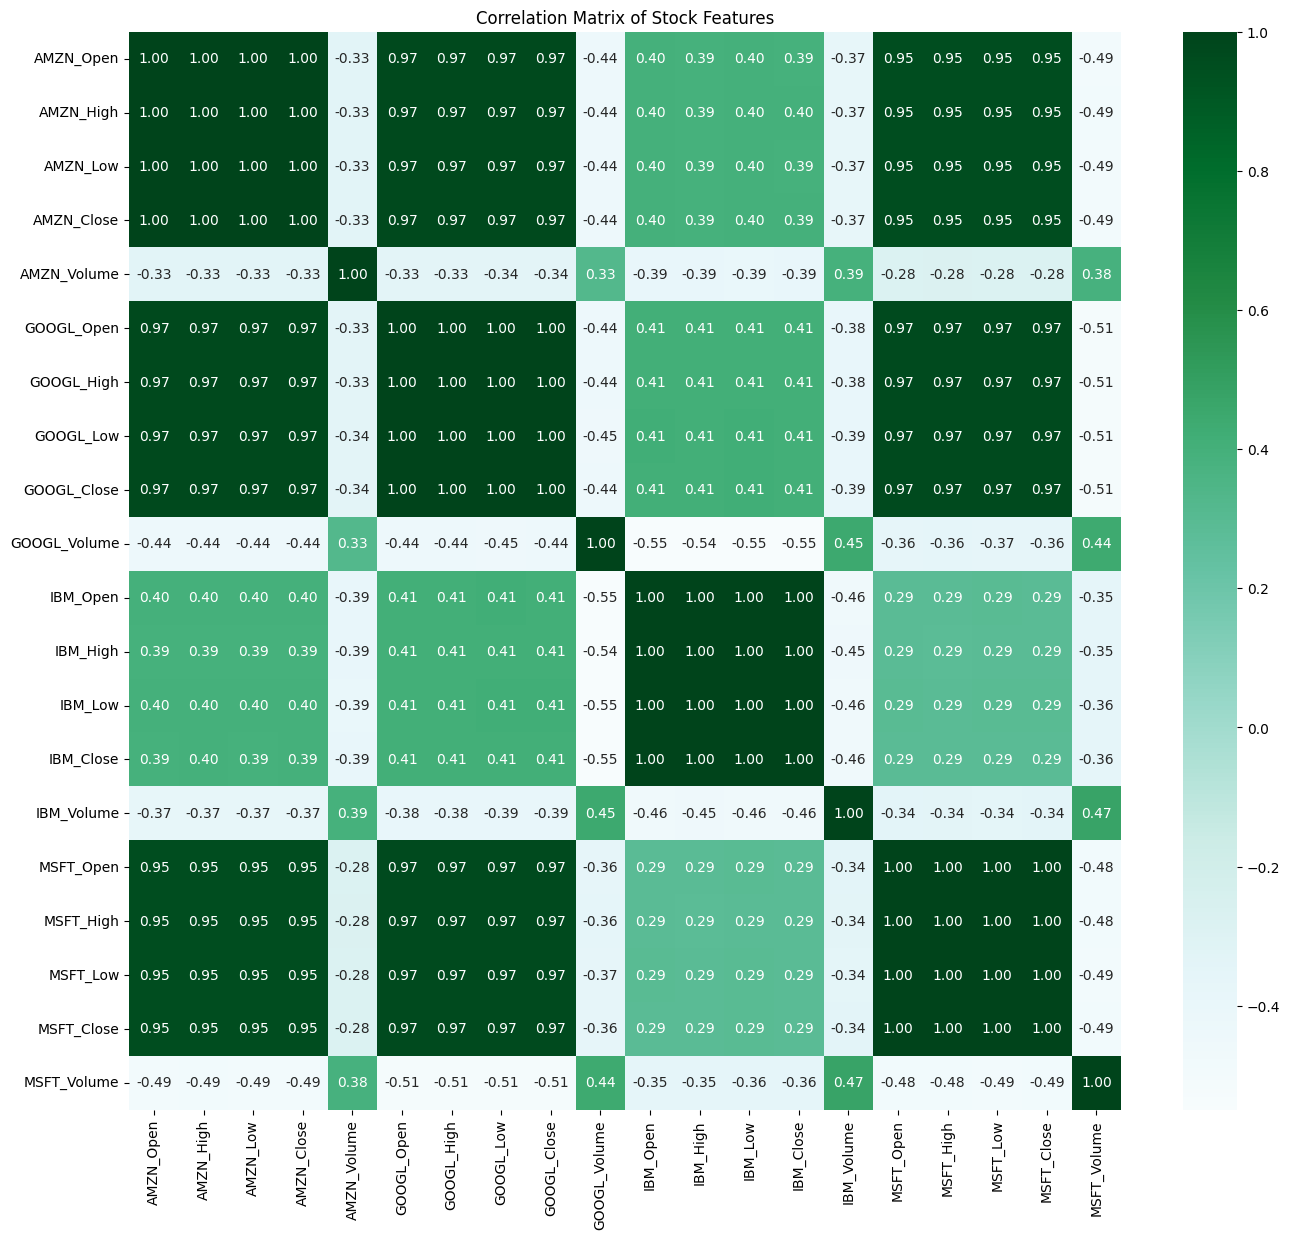

In [12]:
# Analyse correlations

correlation_matrix = merged_stocks_df.corr(numeric_only=True)

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True,
            fmt='.2f', cmap='BuGn')
plt.title('Correlation Matrix of Stock Features')
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [13]:
# Define a function that divides the data into windows and generates target variable values for each window

def generate_X_and_y(df, window_size=20, reqColumns=["AMZN", "GOOGL", "IBM", "MSFT"]):
    df = df.drop(columns=["Date"], errors="ignore")
    reqColumns = [f"{stock}_Close" for stock in reqColumns]
    X=[]
    y=[]

    for i in range(len(df) - window_size):
        input = df.iloc[i:i + window_size].values
        output = df.iloc[i + window_size][reqColumns].values
        X.append(input)
        y.append(output)
    
    return np.array(X), np.array(y)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [14]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scaleData(X_train, X_test, y_train, y_test):
    # Initialize the MinMaxScaler for both features and target variables
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))

    # Create arrays to hold the scaled training and testing data
    X_train_scaled = np.zeros_like(X_train, dtype=np.float32)
    y_train_scaled = np.zeros_like(y_train, dtype=np.float32)

    # Scale the training features and target values incrementally
    for i in range(X_train.shape[0]):
        window = X_train[i]
        target = y_train[i]

        # Fit the scaler on the current window (features) and target (y) incrementally
        # Fit the scaler incrementally on features
        feature_scaler.partial_fit(window)
        # Fit the scaler incrementally on target
        target_scaler.partial_fit(target.reshape(-1, 1))

        # Scale the current window (features) and target (y)
        X_train_scaled[i] = feature_scaler.transform(window)
        y_train_scaled[i] = target_scaler.transform(
            target.reshape(-1, 1)).flatten()

    # Now scale the testing data using the fitted scaler
    X_test_scaled = np.zeros_like(X_test, dtype=np.float32)
    y_test_scaled = np.zeros_like(y_test, dtype=np.float32)

    for i in range(X_test.shape[0]):
        window = X_test[i]
        target = y_test[i]

        # Scale the features and target using the same scaler (without fitting)
        X_test_scaled[i] = feature_scaler.transform(window)
        y_test_scaled[i] = target_scaler.transform(
            target.reshape(-1, 1)).flatten()

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, target_scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [15]:
# Define a function to create input and output data points from the master DataFrame

def prepare_train_val_sets(
    df,
    target_stocks=["AMZN", "GOOGL", "IBM", "MSFT"],
    window_size=20,
    window_stride=1,
    split_ratio=0.8
):

    # Step 1: Generate windowed features and targets
    X, y = generate_X_and_y(
        df.copy(), window_size=window_size, reqColumns=target_stocks)

    # Step 2: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1-split_ratio, shuffle=False)
    
    # Step 3: Scale the training and testing data
    X_train_scaled, X_test_scaled, y_train, y_test,y_scalar = scaleData(
        X_train, X_test, y_train, y_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, y_scalar

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

/var/folders/5n/zn4pdw1j5bq14bmthb_zx3dh0000gr/T/ipykernel_5954/2237871921.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = stocks_analysis_df.resample('M').mean()
/var/folders/5n/zn4pdw1j5bq14bmthb_zx3dh0000gr/T/ipykernel_5954/2237871921.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_quarterly = stocks_analysis_df.resample('Q').mean()


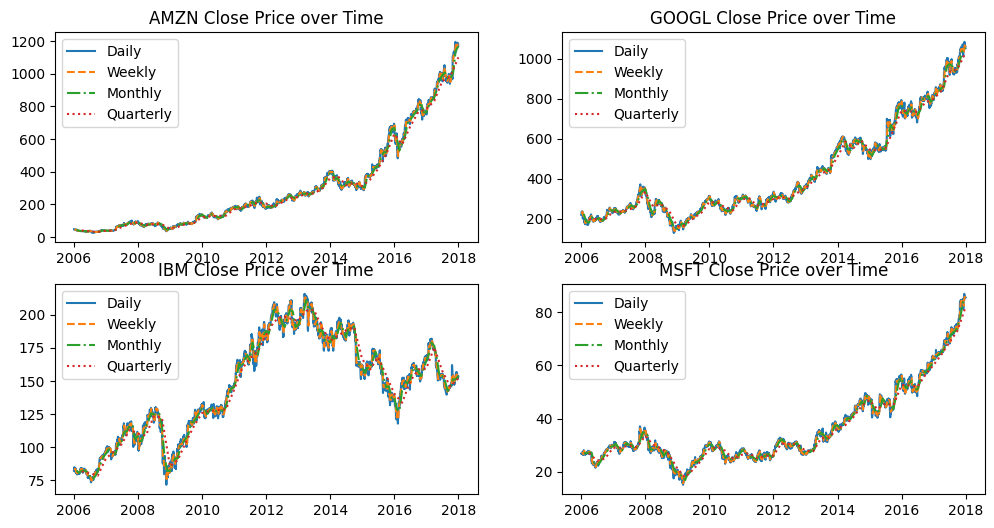

In [16]:
# Checking for patterns in different sequence lengths

stocks_analysis_df = merged_stocks_df.copy()
stocks_analysis_df['Date'] = pd.to_datetime(stocks_analysis_df['Date'])
stocks_analysis_df.set_index('Date', inplace=True)

# Resample for weekly, monthly, and quarterly
df_weekly = stocks_analysis_df.resample('W').mean()
df_monthly = stocks_analysis_df.resample('M').mean()
df_quarterly = stocks_analysis_df.resample('Q').mean()

# Plot the stock prices
plt.figure(figsize=(12, 6))

stocks = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
for i,stock in enumerate(stocks):

# Amazon stock prices
    plt.subplot(2, 2, i+1)
    plt.plot(stocks_analysis_df['{}_Close'.format(stock)], label='Daily')
    plt.plot(df_weekly['{}_Close'.format(stock)],
             label='Weekly', linestyle='--')
    plt.plot(df_monthly['{}_Close'.format(stock)],
             label='Monthly', linestyle='-.')
    plt.plot(df_quarterly['{}_Close'.format(stock)],
             label='Quarterly', linestyle=':')
    plt.title("{} Close Price over Time".format(stock))
    plt.legend()


plt.show()

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [17]:
# Create data instances from the master data frame using decided window size and window stride

window_size = 30
step_size = 1
target_names = ['AMZN']

# Prepare data
X_train_scaled, X_test_scaled, y_train, y_test, y_scaler = prepare_train_val_sets(
    merged_stocks_df, target_names, window_size, step_size, split_ratio=0.8
)

In [18]:
# Check the number of data points generated

print(f"X_train shape: {X_train_scaled.shape}")
print(f"X_val shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_test.shape}")

X_train shape: (2391, 30, 20)
X_val shape: (598, 30, 20)
y_train shape: (2391, 1)
y_val shape: (598, 1)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [19]:
# Check if the datasets are compatible inputs to neural networks

'''
To ensure that the datasets (X and y) are compatible inputs to neural networks, we need to verify the following aspects:

1. Shape of X (Input Features):
For time series prediction using recurrent neural networks (RNNs), the input data (X) should have a 3-dimensional shape: (num_samples, window_size, num_features)
num_samples: The number of windows (data points) in the dataset.
window_size: The number of time steps per window.
num_features: The number of features in each time step (e.g., stock data for multiple companies, if you're predicting multiple stocks).

2. Shape of y (Target Values):
The target data (y) should be a 2-dimensional array: (num_samples, num_targets)
num_samples: The same number of samples (windows) as in X.
num_targets: The number of target variables, i.e., the number of stocks you're predicting (e.g., 1 for single stock or more if predicting multiple stocks).
'''

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_scaled shape: (2391, 30, 20)
X_test_scaled shape: (598, 30, 20)
y_train shape: (2391, 1)
y_test shape: (598, 1)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [20]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def simple_rnn_model(input_shape, output_size,
                           rnn_units=50, dense_units=32,
                           dropout_rate=0.2, learning_rate=0.001):
    
    model = Sequential()
    # helps with vanishing gradients
    model.add(SimpleRNN(rnn_units, input_shape=input_shape,
              kernel_initializer='glorot_uniform'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(output_size))  # Linear output for regression

    # Clip gradients to prevent exploding
    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='mse')

    return model

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [21]:
# Find an optimal configuration of simple RNN

rnn_units_list = [32, 64, 128]
dense_units_list = [16, 32, 64]
dropout_list = [0.1, 0.3, 0.5]
learning_rate_list = [0.001, 0.005]

param_grid = list(product(rnn_units_list, dense_units_list,
                  dropout_list, learning_rate_list))

best_model = None
best_val_loss = float('inf')
best_config = None
history_records = {}

for rnn_units, dense_units, dropout, lr in param_grid:
    print(
        f"Trying RNN={rnn_units}, Dense={dense_units}, Dropout={dropout}, LR={lr}")

    model = simple_rnn_model(
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
        output_size=y_train.shape[1],
        rnn_units=rnn_units,
        dense_units=dense_units,
        dropout_rate=dropout,
        learning_rate=lr
    )

    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=20,  # can increase if needed
        batch_size=32,
        verbose=0  # Turn off for clean output
    )

    val_loss = model.evaluate(X_test_scaled, y_test, verbose=0)
    history_records[(rnn_units, dense_units, dropout, lr)] = val_loss

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_config = (rnn_units, dense_units, dropout, lr)

Trying RNN=32, Dense=16, Dropout=0.1, LR=0.001


/Users/ashriyan/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trying RNN=32, Dense=16, Dropout=0.1, LR=0.005
Trying RNN=32, Dense=16, Dropout=0.3, LR=0.001
Trying RNN=32, Dense=16, Dropout=0.3, LR=0.005
Trying RNN=32, Dense=16, Dropout=0.5, LR=0.001
Trying RNN=32, Dense=16, Dropout=0.5, LR=0.005
Trying RNN=32, Dense=32, Dropout=0.1, LR=0.001
Trying RNN=32, Dense=32, Dropout=0.1, LR=0.005
Trying RNN=32, Dense=32, Dropout=0.3, LR=0.001
Trying RNN=32, Dense=32, Dropout=0.3, LR=0.005
Trying RNN=32, Dense=32, Dropout=0.5, LR=0.001
Trying RNN=32, Dense=32, Dropout=0.5, LR=0.005
Trying RNN=32, Dense=64, Dropout=0.1, LR=0.001
Trying RNN=32, Dense=64, Dropout=0.1, LR=0.005
Trying RNN=32, Dense=64, Dropout=0.3, LR=0.001
Trying RNN=32, Dense=64, Dropout=0.3, LR=0.005
Trying RNN=32, Dense=64, Dropout=0.5, LR=0.001
Trying RNN=32, Dense=64, Dropout=0.5, LR=0.005
Trying RNN=64, Dense=16, Dropout=0.1, LR=0.001
Trying RNN=64, Dense=16, Dropout=0.1, LR=0.005
Trying RNN=64, Dense=16, Dropout=0.3, LR=0.001
Trying RNN=64, Dense=16, Dropout=0.3, LR=0.005
Trying RNN=64

In [22]:
# Find the best configuration based on evaluation metrics

print("\nBest Configuration:")
print(f"RNN Units: {best_config[0]}")
print(f"Dense Units: {best_config[1]}")
print(f"Dropout Rate: {best_config[2]}")
print(f"Learning Rate: {best_config[3]}")
print(f"Validation MSE: {best_val_loss:.4f}")

sorted_records = sorted(history_records.items(), key=lambda x: x[1])
print("\nTop Configurations (sorted by validation loss):\n")
for config, loss in sorted_records:
    print(
        f"RNN={config[0]}, Dense={config[1]}, Dropout={config[2]}, LR={config[3]} --> Val Loss: {loss:.4f}")


Best Configuration:
RNN Units: 128
Dense Units: 16
Dropout Rate: 0.3
Learning Rate: 0.001
Validation MSE: 0.0413

Top Configurations (sorted by validation loss):

RNN=128, Dense=16, Dropout=0.3, LR=0.001 --> Val Loss: 0.0413
RNN=64, Dense=64, Dropout=0.1, LR=0.001 --> Val Loss: 0.0467
RNN=64, Dense=16, Dropout=0.1, LR=0.001 --> Val Loss: 0.0497
RNN=128, Dense=64, Dropout=0.1, LR=0.001 --> Val Loss: 0.0497
RNN=128, Dense=32, Dropout=0.1, LR=0.001 --> Val Loss: 0.0520
RNN=32, Dense=64, Dropout=0.1, LR=0.001 --> Val Loss: 0.0551
RNN=128, Dense=16, Dropout=0.5, LR=0.001 --> Val Loss: 0.0619
RNN=64, Dense=32, Dropout=0.1, LR=0.001 --> Val Loss: 0.0641
RNN=128, Dense=64, Dropout=0.1, LR=0.005 --> Val Loss: 0.0656
RNN=128, Dense=32, Dropout=0.3, LR=0.001 --> Val Loss: 0.0699
RNN=32, Dense=32, Dropout=0.1, LR=0.005 --> Val Loss: 0.0787
RNN=32, Dense=16, Dropout=0.1, LR=0.005 --> Val Loss: 0.0799
RNN=64, Dense=32, Dropout=0.1, LR=0.005 --> Val Loss: 0.0806
RNN=64, Dense=32, Dropout=0.3, LR=0.0

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [31]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
best_model = simple_rnn_model(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    output_size=y_train.shape[1],
    rnn_units=128,
    dense_units=16,
    dropout_rate=0.3,
    learning_rate=0.001
)


# Train the model
history = best_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,               
    batch_size=32,          
    verbose=1              
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1219 - val_loss: 0.3427
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.2686
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.2145
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.2027
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.1667
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.1893
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.1407
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.1636
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.1070
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.1166
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.1022
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_lo

Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


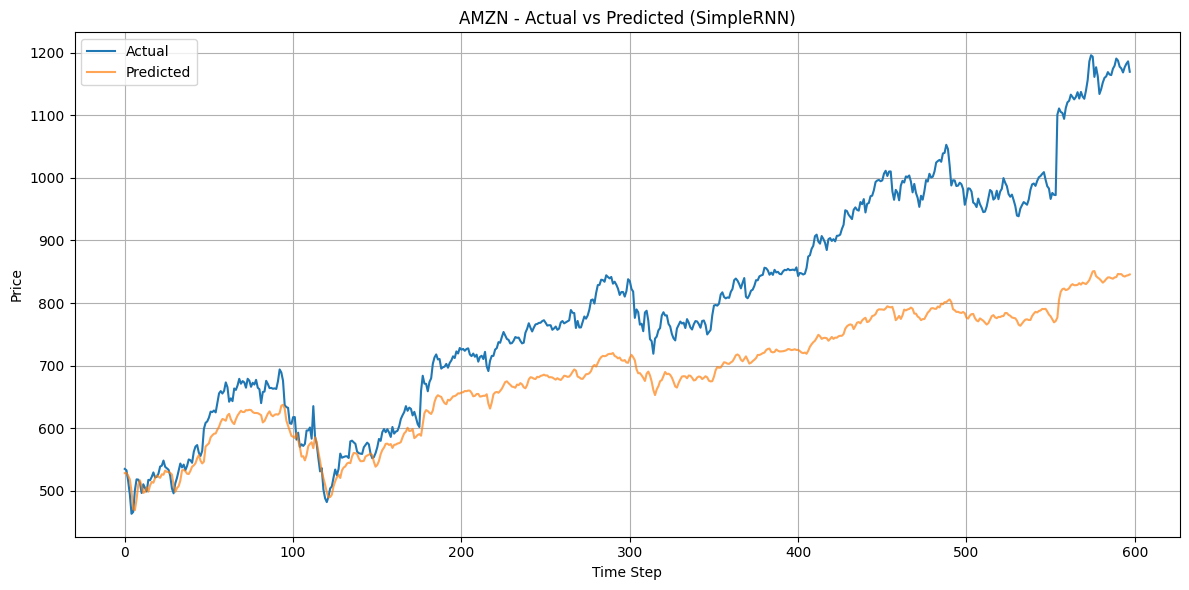

In [32]:
# Predict on the test data and plot

y_pred_rnn_scaled = best_model.predict(X_test_scaled)

# Inverse transform predictions and actual values
y_val_inverse_rnn = y_scaler.inverse_transform(y_test)
y_pred_inverse_rnn = y_scaler.inverse_transform(y_pred_rnn_scaled)


# Choose stock index (0 for AMZN)
stock_index = 0
stock_name = "AMZN"

plt.figure(figsize=(12, 6))
plt.plot(y_val_inverse_rnn[:, stock_index], label="Actual")
plt.plot(y_pred_inverse_rnn[:, stock_index], label="Predicted", alpha=0.7)
plt.title(f"{stock_name} - Actual vs Predicted (SimpleRNN)")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [25]:
# Compute the performance of the model on the testing data set

mse_rnn = mean_squared_error(y_val_inverse_rnn, y_pred_inverse_rnn)
rmse_rnn = np.sqrt(mse_rnn)
mae_rnn = mean_absolute_error(y_val_inverse_rnn, y_pred_inverse_rnn)
r2_rnn = r2_score(y_val_inverse_rnn, y_pred_inverse_rnn)

print(f"SimpleRNN Test MSE: {mse_rnn:.4f}")
print(f"SimpleRNN Test RMSE: {rmse_rnn:.4f}")
print(f"SimpleRNN Test MAE: {mae_rnn:.4f}")
print(f"SimpleRNN Test R² Score: {r2_rnn:.4f}")

SimpleRNN Test MSE: 25428.1543
SimpleRNN Test RMSE: 159.4621
SimpleRNN Test MAE: 129.0381
SimpleRNN Test R² Score: 0.2051


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [26]:
# # Define a function to create a model and specify default values for hyperparameters

def GRUModel(input_shape, output_size,
                    gru_units=32, dense_units=32,
                    dropout_rate=0.1, learning_rate=0.001):
    
    model = Sequential()
    # helps with vanishing gradients
    model.add(GRU(gru_units, input_shape=input_shape,
              kernel_initializer='glorot_uniform'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(output_size))  

    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='mse')

    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [27]:
# Find an optimal configuration

rnn_units_list = [32, 64]
dense_units_list = [16, 32]
dropout_rates = [0.1, 0.2]
learning_rates = [0.001, 0.0005]

# To store results
history_records = {}

# Manual hyperparameter tuning loop
for rnn_units in rnn_units_list:
    for dense_units in dense_units_list:
        for dropout in dropout_rates:
            for lr in learning_rates:
                print(
                    f"Trying GRU={rnn_units}, Dense={dense_units}, Dropout={dropout}, LR={lr}")

                # Build the model
                model = GRUModel(
                    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
                    output_size=y_train.shape[1],
                    gru_units=rnn_units,
                    dense_units=dense_units,
                    dropout_rate=dropout,
                    learning_rate=lr
                )

                # Train the model (keep epochs short for tuning)
                history = model.fit(
                    X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=10,
                    batch_size=32,
                    verbose=0  # set to 1 if you want training logs
                )

                # Last epoch val loss
                val_loss = history.history['val_loss'][-1]
                history_records[(rnn_units, dense_units,
                                 dropout, lr)] = val_loss

Trying GRU=32, Dense=16, Dropout=0.1, LR=0.001


/Users/ashriyan/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trying GRU=32, Dense=16, Dropout=0.1, LR=0.0005
Trying GRU=32, Dense=16, Dropout=0.2, LR=0.001
Trying GRU=32, Dense=16, Dropout=0.2, LR=0.0005
Trying GRU=32, Dense=32, Dropout=0.1, LR=0.001
Trying GRU=32, Dense=32, Dropout=0.1, LR=0.0005
Trying GRU=32, Dense=32, Dropout=0.2, LR=0.001
Trying GRU=32, Dense=32, Dropout=0.2, LR=0.0005
Trying GRU=64, Dense=16, Dropout=0.1, LR=0.001
Trying GRU=64, Dense=16, Dropout=0.1, LR=0.0005
Trying GRU=64, Dense=16, Dropout=0.2, LR=0.001
Trying GRU=64, Dense=16, Dropout=0.2, LR=0.0005
Trying GRU=64, Dense=32, Dropout=0.1, LR=0.001
Trying GRU=64, Dense=32, Dropout=0.1, LR=0.0005
Trying GRU=64, Dense=32, Dropout=0.2, LR=0.001
Trying GRU=64, Dense=32, Dropout=0.2, LR=0.0005


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [28]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

best_gru_units = 64
best_dense_units = 16
best_dropout = 0.2
best_lr = 0.001

# Build the best model
final_gru_model = GRUModel(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    output_size=y_train.shape[1],
    gru_units=best_gru_units,
    dense_units=best_dense_units,
    dropout_rate=best_dropout,
    learning_rate=best_lr
)

# Train the final model (you can increase epochs now)
final_history = final_gru_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,  # Can increase if needed
    batch_size=32,
    verbose=1
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1343 - val_loss: 0.2824
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0150 - val_loss: 0.1875
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0110 - val_loss: 0.1555
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - val_loss: 0.1217
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.1332
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - val_loss: 0.1079
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0079 - val_loss: 0.0707
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - val_loss: 0.0835
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.1057
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0065 - val_loss: 0.1155
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.1191
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0066 - val_lo

In [33]:
# Compute the performance of the model on the testing data set
test_loss = final_gru_model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test MSE Loss: {test_loss:.4f}")

# Predict on validation set
y_pred_scaled = final_gru_model.predict(X_test_scaled)

# Inverse transform both predictions and actual values
y_val_inverse = y_scaler.inverse_transform(y_test)
y_pred_inverse = y_scaler.inverse_transform(y_pred_scaled)

# Compute metrics
mse = mean_squared_error(y_val_inverse, y_pred_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_inverse, y_pred_inverse)
r2 = r2_score(y_val_inverse, y_pred_inverse)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0052 
Test MSE Loss: 0.0088
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test RMSE: 47.9064
Test MAE: 41.5364
Test R² Score: 0.9283


Plotting the actual vs predicted values

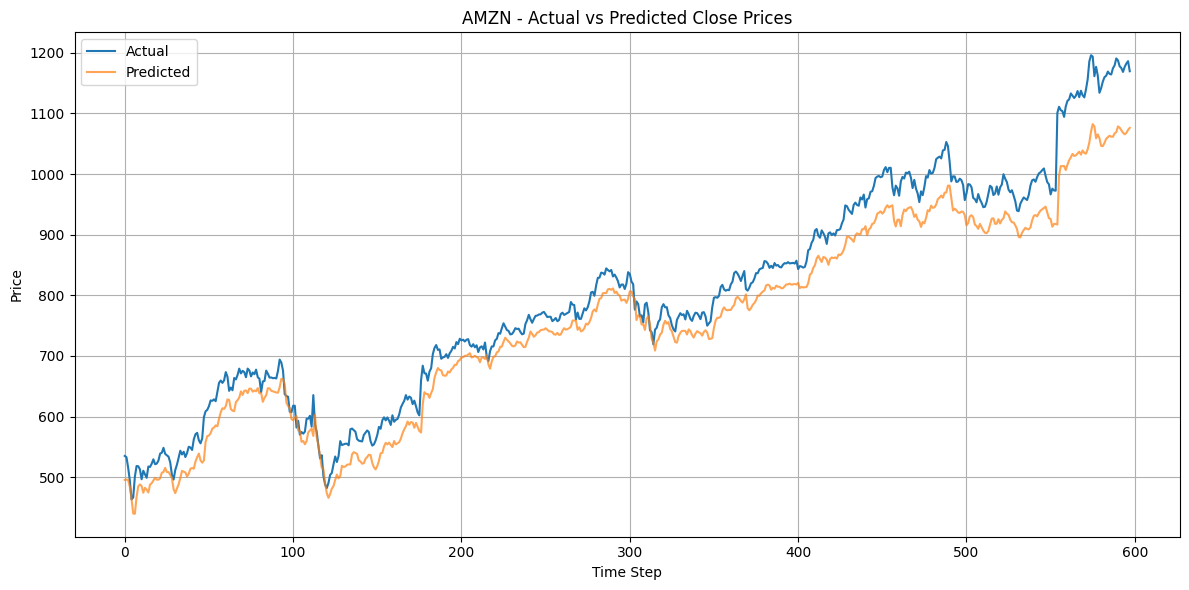

In [34]:
# Predict on the test data

stock_index = 0
stock_name = "AMZN"

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_val_inverse[:, stock_index], label="Actual")
plt.plot(y_pred_inverse[:, stock_index], label="Predicted", alpha=0.7)
plt.title(f"{stock_name} - Actual vs Predicted Close Prices")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

**EDA and Visualization Insights:** 

EDA revealed notable variations in stock price movements throughout the time series, particularly for stocks such as AMZN.

The analysis showed market dynamics characterized by periods of intense price swings, including both rapid upward movements and sudden downward corrections.

Through visualization of the data, we identified recurring patterns and seasonal trends, coupled with an overall positive trajectory over extended periods.

The data exhibited distinct time-based patterns, with price movements occurring in sequential phases that often aligned with market developments and quarterly business cycles.

The analysis demonstrated that stock prices display clear temporal relationships, making them well-suited for time series analysis and forecasting models.


**Performance of SimpleRNN:**  
The SimpleRNN model had the following performance:

* SimpleRNN Test MSE: 25428.1543
* SimpleRNN Test RMSE: 159.4621
* SimpleRNN Test MAE: 129.0381
* SimpleRNN Test R² Score: 0.2051


Based on the analysis of performance metrics and visualization of Actual vs Predicted values:

The SimpleRNN model demonstrated an ability to track the general directional movements of stock prices.

The model's primary limitation was its difficulty in accurately predicting extreme price movements, resulting in delayed responses to significant market changes.

Assessment: While the SimpleRNN provided adequate baseline performance, its capabilities fell short for practical stock price prediction, particularly in markets characterized by high volatility where precision is crucial.

Next Steps: These limitations motivated the exploration of the GRU (Gated Recurrent Unit) architecture, which offers enhanced capabilities in processing sequential data and maintaining longer-term memory patterns.


**Performance of GRU:**  

* Test MSE Loss: 0.0088
* Test RMSE: 47.9064
* Test MAE: 41.5364
* Test R² Score: 0.9283

Performance Analysis:

The GRU model demonstrated superior performance metrics, exhibiting reduced error rates and an improved R² score when compared to the SimpleRNN implementation.

A notable strength of the GRU architecture was its capacity to accurately track stock price movements, maintaining precision even during periods of market volatility.

Key Finding: The GRU model proved to be substantially more effective for this particular dataset, primarily due to its advanced architecture that successfully captures complex temporal relationships and adapts to rapid market changes. Its sophisticated gating mechanisms provided a clear advantage over the SimpleRNN approach.

**Final Observations:**  
* The GRU architecture demonstrated robust performance in stock price prediction, delivering consistent and dependable results.

* While the current GRU implementation proved effective, there remains potential for enhanced performance through advanced architectures such as:
    * Long Short-Term Memory (LSTM) networks
    * Bidirectional GRU implementations
    * Integration of Attention mechanisms

* Key Findings:
    * SimpleRNN's limitations in memory retention make it inadequate for complex stock price prediction
    * Advanced RNN variants, particularly GRU, show strong capability in processing financial time series data
    * The success of GRU suggests that sophisticated RNN architectures (including LSTM) are well-suited for stock market forecasting applications

This analysis confirms that while basic RNN architectures may fall short, modern variants like GRU provide a solid foundation for stock price prediction tasks, with room for further optimization through more sophisticated approaches.